In [102]:
import itertools
from datetime import datetime
from pathlib import Path

import geowombat as gw
# from tsplanet import download_data

import geopandas as gpd
import numpy as np
import sklearn_crfsuite
from affine import Affine
import matplotlib.pyplot as plt

## Download PlanetScope data

In [2]:
# download_data('/scratch/rsc4/graesser/temp/planet',
#               '/export/home/graesserj/code/python/github/planet/tsplanet/geojson/qld.geojson',
#               '2019-08-01', 
#               '2019-08-10',
#               cloud_cover=0.8,
#               api_key='des')

## Extract samples from training AOIs

In [77]:
# planet_dir = Path('/scratch/rsc4/graesser/temp/planet')
planet_dir = Path('/media/jcgr/data/imagery/planet/pry')

In [84]:
# filenames = ['20190802_234446_0f31_3B_AnalyticMS_SR',
#              '20190804_234646_100a_3B_AnalyticMS_SR', 
#              '20190809_234600_104a_3B_AnalyticMS_SR',
#              '20190809_234852_0f2a_3B_AnalyticMS_SR',
#              '20190812_234445_1005_3B_AnalyticMS_SR']

filenames = ['20180111_131258_1024_3B_AnalyticMS_SR.tif', 
             '20180111_131300_1024_3B_AnalyticMS_SR.tif', 
             '20180117_131442_0e0e_3B_AnalyticMS_SR.tif',
             '20180129_131341_1030_3B_AnalyticMS_SR.tif',
             '20180129_131340_1030_3B_AnalyticMS_SR.tif',
             '20180413_131755_1038_3B_AnalyticMS_SR.tif',
             '20180413_131754_1038_3B_AnalyticMS_SR.tif',
             '20180419_144202_1053_3B_AnalyticMS_SR.tif']

In [79]:
time_names = [datetime.strptime(Path(fn).name.split('_')[0], '%Y%m%d') for fn in filenames]

In [85]:
rasters = [planet_dir.joinpath('raster').joinpath(fn).as_posix() for fn in filenames]
vector = planet_dir.joinpath('cloud_training/training01.shp').as_posix()

### Plot the intersection

In [57]:
with gw.config.update(ref_image=rasters[0], 
                      ref_res=(10, 10), 
                      sensor='planetscope'):
    
    with gw.open(rasters,
                 time_names=time_names,
                 how='intersection',
                 chunks=512) as ds:
        
        dss = ds.mean(dim='time')
        dss.attrs = ds.attrs
        print(ds)
        
        #dss.gw.imshow(band_names=['red', 'green', 'blue'], nodata=0, robust=True)

<xarray.DataArray (time: 5, band: 4, y: 2231, x: 4508)>
dask.array<concatenate, shape=(5, 4, 2231, 4508), dtype=float64, chunksize=(1, 4, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U5 'blue' 'green' 'red' 'nir'
  * x        (x) float64 6.12e+05 6.12e+05 6.12e+05 ... 6.57e+05 6.57e+05
  * y        (y) float64 7.222e+06 7.222e+06 7.222e+06 ... 7.245e+06 7.245e+06
  * time     (time) datetime64[ns] 2018-01-11 2018-01-17 ... 2018-04-19
Attributes:
    crs:         +init=epsg:32721
    res:         (10.0, 10.0)
    is_tiled:    1
    nodatavals:  (0.0, 0.0, 0.0, 0.0)
    scales:      (1.0, 1.0, 1.0, 1.0)
    offsets:     (0.0, 0.0, 0.0, 0.0)


### Extract samples

In [112]:
df = gpd.read_file(vector)
out = df.series.str.split(',', expand=True)

df_list = list()

for s in range(0, out.shape[1]):
    df_ = df.copy()
    df_['id'] = out.iloc[:, s]
    df_list.append(df_)

In [113]:
df_list[1].head()

,id,series,geometry
0,3,"1,3,3,4,5","POLYGON ((629703.088 7232877.628, 629703.088 7..."
1,1,"1,1,3,1,5","POLYGON ((631275.798 7232986.580, 631275.798 7..."
2,1,"1,1,3,3,5","POLYGON ((633182.322 7233416.165, 633182.322 7..."


In [118]:
dfs = list()

with gw.config.update(ref_image=rasters[0], 
                      ref_res=(10, 10), 
                      sensor='planetscope'):
    
    with gw.open(rasters[0]) as ds:
        transform = ds.transform

    with gw.open(rasters,
                 time_names=time_names,
                 how='intersection',
                 chunks=512) as ds:    
        
        transform = (ds.res[0], 0.0, ds.x.values[0], 0.0, -ds.res[1], ds.y.values[0])

        for ti, time in enumerate(ds.time.values):
            
            dss = ds.sel(time=time)
            dss.attrs = ds.attrs
            dss.attrs['transform'] = transform
            
            dfs.append(dss.gw.extract(df_list[ti], frac=0.5))

100%|██████████| 3/3 [00:00<00:00, 126.89it/s]


In [119]:
dfs[0].head()

,poly,point,geometry,blue,green,red,nir
0,1,0,POINT (629705.000 7210635.000),1092.0,1244.0,1188.0,3964.0
1,1,1,POINT (629735.000 7210685.000),1082.0,1275.0,1245.0,4419.0
2,1,2,POINT (629785.000 7210745.000),1135.0,1252.0,1239.0,4992.0
3,1,3,POINT (629775.000 7210605.000),970.0,1109.0,1109.0,3698.0
4,1,4,POINT (629755.000 7210735.000),1128.0,1267.0,1236.0,4858.0


In [120]:
dfs[1].poly.unique()

array([3, 1])

## Convert samples to CRF features

In [121]:
band_names = ['blue', 'green', 'red', 'nir']
label_name = 'poly'
label_dict = {0: 'nodata', 1: 'land', 2: 'water', 3: 'cloud', 4: 'shadow', 5: 'haze'}

In [122]:
def label_decoder(label):
    return label_dict[label]


def get_sample_xy(sample):
    return dict(zip(band_names, np.float64(sample[band_names].values))), label_decoder(int(sample.poly))


def get_array_xy(sample):
    return dict(zip(band_names, sample))

    
def samples_to_features(dfs):
    
    """
    sample = [[{t1}, {t2}, ..., {tn}], ..., [...]]
    """
    
    return [list(zip(*df.apply(get_sample_xy, axis=1))) for df in dfs]


def array_to_dict(*args):
    return [dict(zip(band_names, sample)) for sample in args]

In [123]:
results = samples_to_features(dfs)

### CRF X and y

In [124]:
X = np.array(list(zip(*results))[0]).T.tolist()
print(len(X))

656


In [125]:
y = np.array(list(zip(*results))[1]).T.tolist()
print(len(y))

656


### Fit the model

In [128]:
model = sklearn_crfsuite.CRF(algorithm='lbfgs', # Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
            c1=0.001,
            c2=0.001,
            max_iterations=1000,
            num_memories=10,
            period=10,
            epsilon=1e-06,
            delta=1e-06,
            linesearch='StrongBacktracking',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
            max_linesearch=20,
            all_possible_states=True,
            all_possible_transitions=True,
            verbose=False)

In [129]:
model.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=True, all_possible_transitions=True,
    averaging=None, c=None, c1=0.001, c2=0.001, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=1e-06, epsilon=1e-06, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch='StrongBacktracking',
    max_iterations=1000, max_linesearch=20, min_freq=None, model_filename=None,
    num_memories=10, pa_type=None, period=10, trainer_cls=None, variance=None,
    verbose=False)

In [130]:
model.predict_marginals(X)[0]

[{'land': 0.999999999997394,
  'cloud': 2.430496124854752e-12,
  'shadow': 1.1146047465376419e-13,
  'haze': 6.471617939948179e-14},
 {'land': 0.34197566368914845,
  'cloud': 0.65802432101735,
  'shadow': 1.529338765462764e-08,
  'haze': 1.142059186660285e-13},
 {'land': 0.0002081702195309783,
  'cloud': 0.9996249011502797,
  'shadow': 0.000166913336452992,
  'haze': 1.5293736553428458e-08},
 {'land': 0.0008454943961941264,
  'cloud': 0.07439850157259002,
  'shadow': 0.9247558708597688,
  'haze': 1.3317144711094049e-07},
 {'land': 1.0528090764036072e-06,
  'cloud': 1.9777681298024694e-05,
  'shadow': 9.03336078442197e-08,
  'haze': 0.9999790791760177}]

In [131]:
# samples x time x n classes
# pred = np.array([[[ps['land'], ps['cloud']] for ps in p] for p in model.predict_marginals(X)], dtype='float64')

In [132]:
# pred.shape

### Open the data to predict on 

In [158]:
with gw.config.update(ref_image=rasters[0], ref_res=(5, 5), sensor='planetscope'):
    
    with gw.open(rasters,
                 how='intersection') as ds:
        
        dss = gw.subset(ds, left=629960.209, top=7233224.139, rows=500, cols=500)
        test = dss.astype('float64').data.compute()

In [159]:
ntime, nbands, nrows, ncols = test.shape
nclasses = 4

In [160]:
# X[0]

### Convert the array to CRF-compatible features

In [161]:
# array_to_dict(test[0].transpose(1, 2, 0).reshape(nrows*ncols, nbands)[0],
#               test[1].transpose(1, 2, 0).reshape(nrows*ncols, nbands)[0])

In [162]:
features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in test]
features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

In [163]:
features[0]

[{'blue': 0.0, 'green': 0.0, 'red': 0.0, 'nir': 0.0},
 {'blue': 1086.0, 'green': 1190.0, 'red': 1183.0, 'nir': 4843.0},
 {'blue': 1086.0, 'green': 1190.0, 'red': 1102.0, 'nir': 5160.0},
 {'blue': 2664.0, 'green': 2735.0, 'red': 2635.0, 'nir': 4235.0},
 {'blue': 0.0, 'green': 0.0, 'red': 0.0, 'nir': 0.0},
 {'blue': 1275.0, 'green': 1367.0, 'red': 1342.0, 'nir': 4019.0},
 {'blue': 1089.0, 'green': 1187.0, 'red': 1163.0, 'nir': 4025.0},
 {'blue': 451.0, 'green': 624.0, 'red': 664.0, 'nir': 3275.0}]

### Predict on all time steps

In [164]:
# samples x time x n classes
pred = np.array([[[ps['land'], ps['cloud'], ps['shadow'], ps['haze']] for ps in p] 
                 for p in model.predict_marginals(features)], dtype='float64')

In [165]:
pred[0]

array([[7.24679979e-01, 2.75320016e-01, 4.41416722e-09, 6.86678156e-19],
       [9.99991745e-01, 8.25032921e-06, 3.13469623e-13, 4.46368083e-09],
       [9.99996602e-01, 3.39813605e-06, 4.92321866e-21, 4.12441087e-13],
       [2.60167399e-03, 9.97398326e-01, 2.16195991e-12, 3.86433126e-19],
       [6.45583700e-10, 9.99999999e-01, 2.18119359e-14, 6.21882423e-22],
       [6.41226263e-02, 9.35877300e-01, 5.56131321e-12, 7.40184059e-08],
       [4.03837377e-02, 1.49485003e-02, 9.44667762e-01, 4.36121384e-15],
       [3.28022881e-07, 4.24993097e-09, 1.11809283e-13, 9.99999668e-01]])

In [166]:
pred.shape

(250000, 8, 4)

In [167]:
pred = pred.transpose(1, 2, 0).reshape(ntime, nclasses, nrows, ncols)

In [168]:
pred.shape

(8, 4, 500, 500)

## Plot cloud probabilities

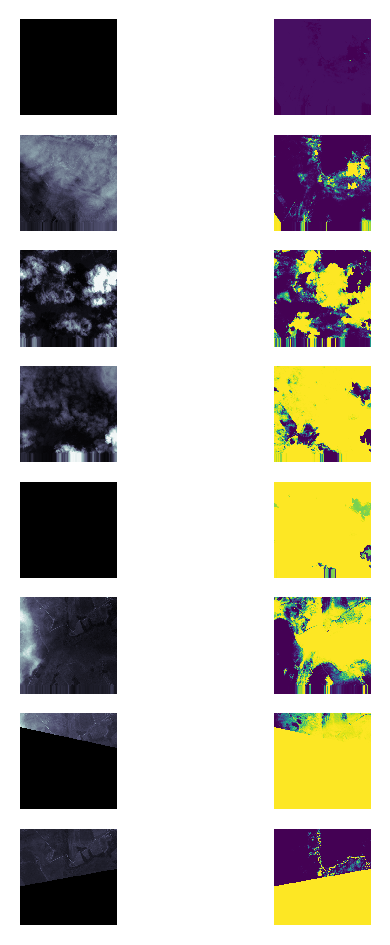

In [169]:
%matplotlib inline

fig, axes = plt.subplots(pred.shape[0], 2, dpi=200, figsize=(3, 6))

bidx = 0 # band index
cidx = 1 # class index

for pi in range(0, pred.shape[0]):

    axes[pi][0].imshow(test[pi, bidx, :, :], cmap='bone')
    axes[pi][1].imshow(pred[pi, cidx, :, :])
    
#     axes[pi][0].set_xlabel('Time {:d}'.format(pi+1))
    
    axes[pi][0].axis('off')
    axes[pi][1].axis('off')

plt.show()

### Shape testing

In [176]:
# a = np.arange(8*3*2).reshape(8,3,2)

In [217]:
# time 1
# a[:, 0, :]

In [218]:
# time 2
# a[:, 1, :]

In [219]:
# a.transpose(1, 2, 0).reshape(3, 2, 2, 4)[1]